In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import os

In [65]:
df = pd.read_csv("../data/nigeria_traffic_data.csv")
df.shape, df.columns

((896, 9),
 Index(['Source', 'Destination', 'Road Length (km)', 'Congestion Level',
        'Average Speed (km/h)', 'Travel Time (min)', 'Weather',
        'Alternative Routes', 'Suitability Score'],
       dtype='object'))

In [66]:
lagos_df = df[(df["Source"] == "Lagos") | (df["Destination"] == "Lagos")].copy()
lagos_df.reset_index(drop=True, inplace=True)

In [67]:
congestion_map = {'Low': 3, 'Medium': 2, 'High': 1}
lagos_df["Congestion Level"] = lagos_df["Congestion Level"].map(congestion_map)


weather_map = {'Clear': 0, 'Cloudy': 1, 'Rainy': 2, 'Foggy': 3}

lagos_df["Weather"] = lagos_df["Weather"].map(weather_map)

lagos_df["direction"] = lagos_df["Source"].apply(lambda x: 1 if x == "Lagos" else 0)

print(f"Before removing duplicates: {len(lagos_df)} rows")
lagos_df = lagos_df.drop_duplicates()
print(f"After removing duplicates: {len(lagos_df)} rows")

# dropping text features and not used columns (including average speed to avoid data leakage)
lagos_df.drop(['Source', 'Destination', 'Alternative Routes', 'Suitability Score', 'Average Speed (km/h)'], axis=1, inplace=True)

print(f"Remaining features: {list(lagos_df.columns)}")
print(f"Unique travel times: {lagos_df['Travel Time (min)'].nunique()}")

Before removing duplicates: 203 rows
After removing duplicates: 203 rows
Remaining features: ['Road Length (km)', 'Congestion Level', 'Travel Time (min)', 'Weather', 'direction']
Unique travel times: 16


DEBUGGING: Checking for data leakage...
Dataset shape: (203, 5)
Columns: ['Road Length (km)', 'Congestion Level', 'Travel Time (min)', 'Weather', 'direction']

First few rows:
   Road Length (km)  Congestion Level  Travel Time (min)  Weather  direction
0        772.262244                 3             501.65        1          1
1        989.642155                 2             653.26        2          1
2        558.684404                 3             404.41        0          1
3        602.375745                 3             496.52        0          0
4        957.130399                 2             676.55        0          1

Duplicate rows: 78
Unique Travel Time values: 16
Total rows: 203

Correlation with Travel Time:
Travel Time (min)    1.000000
Road Length (km)     0.985880
Weather              0.158138
direction            0.025317
Congestion Level     0.002279
Name: Travel Time (min), dtype: float64


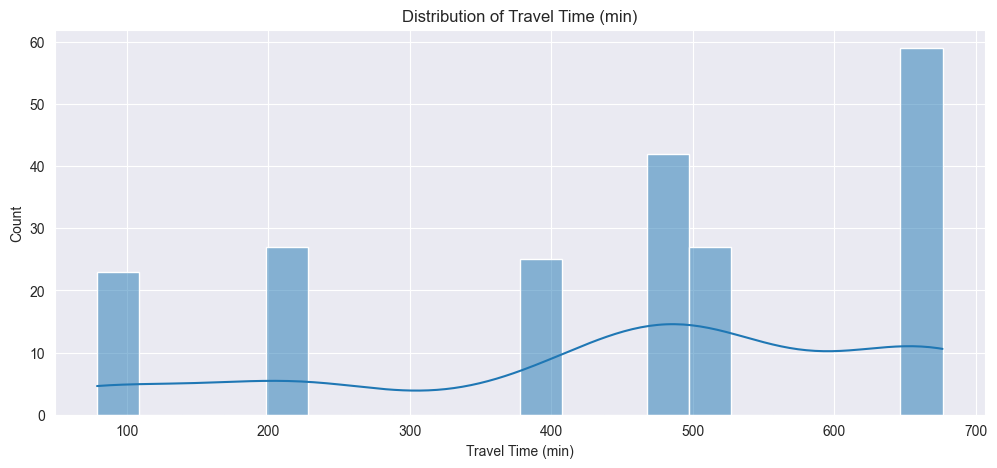

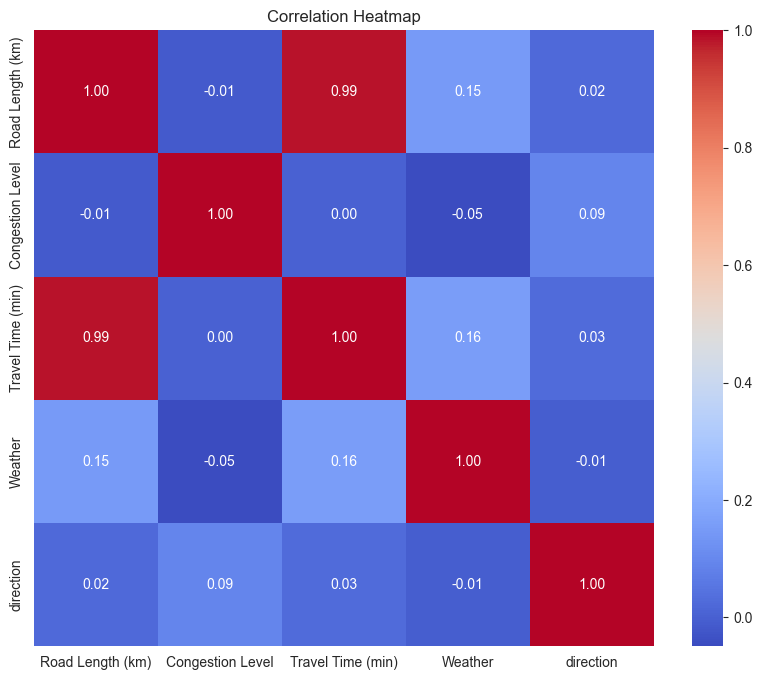

In [68]:
print("DEBUGGING: Checking for data leakage...")
print(f"Dataset shape: {lagos_df.shape}")
print(f"Columns: {list(lagos_df.columns)}")
print("\nFirst few rows:")
print(lagos_df.head())

print(f"\nDuplicate rows: {lagos_df.duplicated().sum()}")
print(f"Unique Travel Time values: {lagos_df['Travel Time (min)'].nunique()}")
print(f"Total rows: {len(lagos_df)}")

print("\nCorrelation with Travel Time:")
correlations = lagos_df.corr()['Travel Time (min)'].abs().sort_values(ascending=False)
print(correlations)

perfect_corr = correlations[correlations >= 0.99]
if len(perfect_corr) > 1: 
    print("Found near-perfect correlations!")
    print(perfect_corr)

plt.figure(figsize=(12, 5))
sns.histplot(lagos_df['Travel Time (min)'], bins=20, kde=True)
plt.title("Distribution of Travel Time (min)")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(lagos_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [69]:
X_base = lagos_df[[
    'Road Length (km)',
    'Weather',
    'direction',
    'Congestion Level'
]]

X = X_base.copy()
X['sqrt_distance'] = np.sqrt(X_base['Road Length (km)'])
X['distance_weather'] = X_base['Road Length (km)'] * X_base['Weather'] / 4  

y = lagos_df['Travel Time (min)']

print(f"Enhanced features: {list(X.columns)}")
print(f"Feature ranges:")
for col in X.columns:
    print(f"  {col}: {X[col].min():.2f} to {X[col].max():.2f}")

print(f"Enhanced features: {list(X.columns)}")

Enhanced features: ['Road Length (km)', 'Weather', 'direction', 'Congestion Level', 'sqrt_distance', 'distance_weather']
Feature ranges:
  Road Length (km): 129.68 to 992.07
  Weather: 0.00 to 3.00
  direction: 0.00 to 1.00
  Congestion Level: 1.00 to 3.00
  sqrt_distance: 11.39 to 31.50
  distance_weather: 0.00 to 744.06
Enhanced features: ['Road Length (km)', 'Weather', 'direction', 'Congestion Level', 'sqrt_distance', 'distance_weather']


In [70]:
print("Data distribution analysis:")
print(f"Distance range: {lagos_df['Road Length (km)'].min():.1f} - {lagos_df['Road Length (km)'].max():.1f} km")
print(f"Travel time range: {lagos_df['Travel Time (min)'].min():.1f} - {lagos_df['Travel Time (min)'].max():.1f} min")

distance_groups = lagos_df.groupby('Road Length (km)')['Travel Time (min)'].agg(['mean', 'count'])
print("\nDistance vs Average Travel Time:")
print(distance_groups.head(10))

print(f"\nRows with travel time < 60 minutes: {(lagos_df['Travel Time (min)'] < 60).sum()}")
print(f"Rows with travel time > 600 minutes: {(lagos_df['Travel Time (min)'] > 600).sum()}")

Data distribution analysis:
Distance range: 129.7 - 992.1 km
Travel time range: 78.8 - 676.5 min

Distance vs Average Travel Time:
                    mean  count
Road Length (km)               
129.681812         78.82     11
130.818797         80.27     12
314.372988        220.65     15
316.024661        220.63     12
558.684404        404.41     15
559.545630        403.02     10
598.656487        492.15     11
602.375745        496.52     10
743.504989        490.07     10
748.175259        487.99     11

Rows with travel time < 60 minutes: 0
Rows with travel time > 600 minutes: 59


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [73]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

In [74]:
dt_model = DecisionTreeRegressor(
    max_depth=2,          
    min_samples_leaf=20,   
    min_samples_split=40,
    random_state=42
)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

In [75]:
rf_model = RandomForestRegressor(
    n_estimators=50,       
    max_depth=3,          
    min_samples_leaf=15,   
    min_samples_split=25,  
    max_features='sqrt',  
    random_state=42
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [76]:
def evaluate_model (name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} - RMSE: {rmse:.2f}, R2: {r2:.3f}")
    return rmse, r2

lr_rmse, lr_r2 = evaluate_model("Linear Regression", y_test, y_pred_lr)
dt_rmse, dt_r2 = evaluate_model("Decision Tree", y_test, y_pred_dt)
rf_rmse, rf_r2 = evaluate_model("Random Forest", y_test, y_pred_rf)

models = {
    'Linear Regression': (lr_model, lr_rmse, y_pred_lr),
    'Decision Tree': (dt_model, dt_rmse, y_pred_dt),
    'Random Forest': (rf_model, rf_rmse, y_pred_rf)
}

best_model_name = min(models.keys(), key=lambda x: models[x][1])
best_model = models[best_model_name][0]
best_predictions = models[best_model_name][2]

print(f"\nBest Model: {best_model_name} (RMSE: {models[best_model_name][1]:.2f})")

Linear Regression - RMSE: 29.45, R2: 0.981
Decision Tree - RMSE: 46.12, R2: 0.954
Random Forest - RMSE: 53.50, R2: 0.937

Best Model: Linear Regression (RMSE: 29.45)


In [77]:
os.makedirs("../models", exist_ok=True)

joblib.dump(best_model, "../models/best_model.pkl")
joblib.dump(scaler, "../models/scaler.pkl")

['../models/scaler.pkl']


Feature Coefficients (Linear Regression):
            feature  coefficient
0  Road Length (km)    98.572849
4     sqrt_distance    90.186303
1           Weather    13.825595
5  distance_weather   -13.335772
3  Congestion Level     4.787152
2         direction    -1.675585


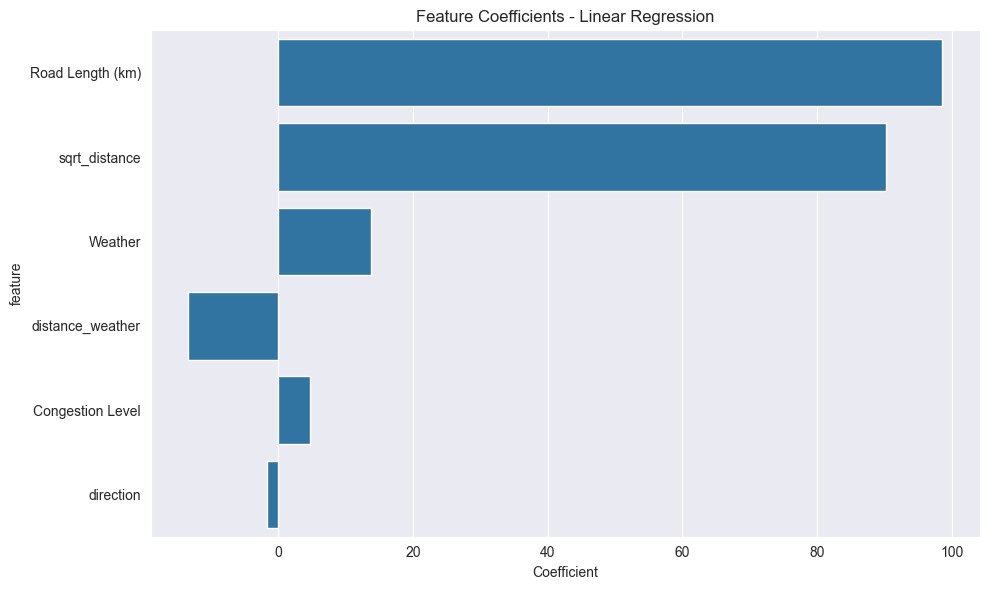

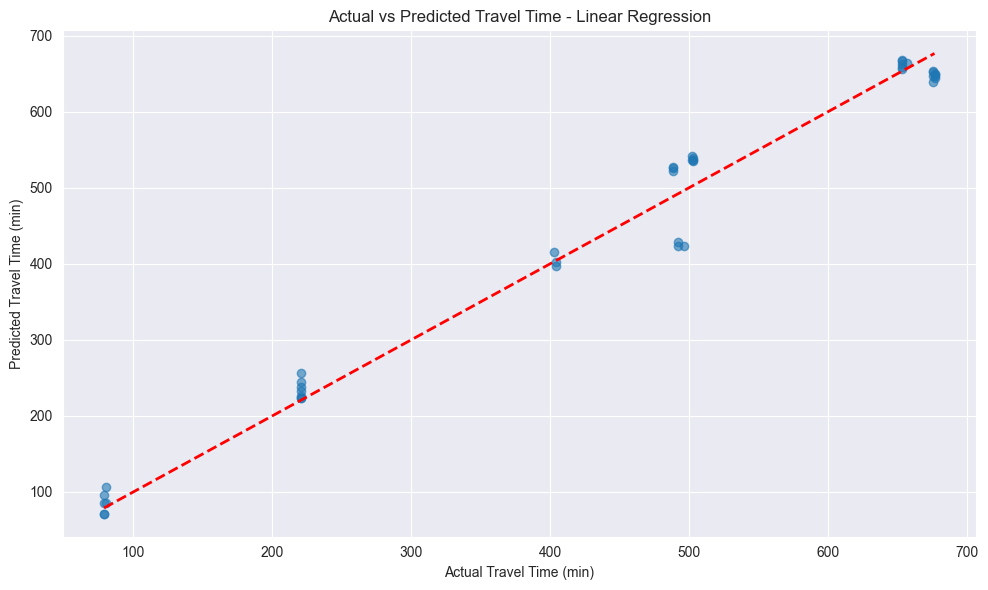

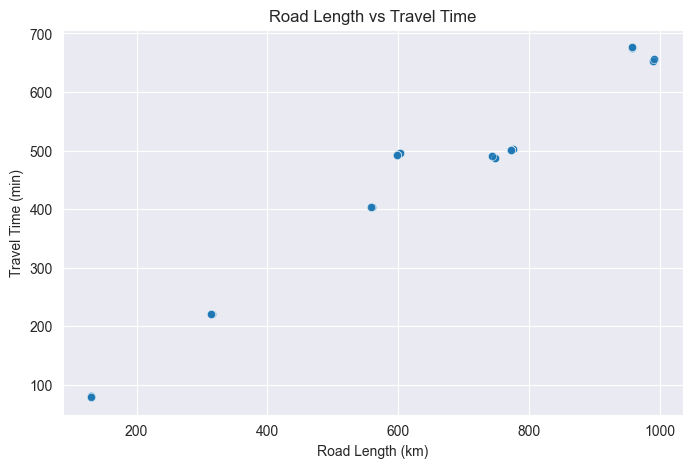

In [78]:
if best_model_name == 'Random Forest':
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nFeature Importance (Random Forest):")
    print(feature_importance)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature')
    plt.title('Feature Importance - Random Forest')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

elif best_model_name == 'Linear Regression':
    feature_coef = pd.DataFrame({
        'feature': X.columns,
        'coefficient': best_model.coef_
    }).sort_values('coefficient', key=abs, ascending=False)
    
    print("\nFeature Coefficients (Linear Regression):")
    print(feature_coef)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_coef, x='coefficient', y='feature')
    plt.title('Feature Coefficients - Linear Regression')
    plt.xlabel('Coefficient')
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Travel Time (min)')
plt.ylabel('Predicted Travel Time (min)')
plt.title(f'Actual vs Predicted Travel Time - {best_model_name}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(x=lagos_df['Road Length (km)'], y=lagos_df['Travel Time (min)'], alpha=0.6)
plt.title("Road Length vs Travel Time")
plt.xlabel("Road Length (km)")
plt.ylabel("Travel Time (min)")
plt.show()

In [79]:
from sklearn.model_selection import cross_val_score

print("Cross-validation scores (5-fold):")

lr_cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
lr_cv_rmse = np.sqrt(-lr_cv_scores.mean())
print(f"Linear Regression CV RMSE: {lr_cv_rmse:.2f} (+/- {np.sqrt(lr_cv_scores.std() * 2):.2f})")

dt_cv_scores = cross_val_score(dt_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
dt_cv_rmse = np.sqrt(-dt_cv_scores.mean())
print(f"Decision Tree CV RMSE: {dt_cv_rmse:.2f} (+/- {np.sqrt(dt_cv_scores.std() * 2):.2f})")

rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rf_cv_rmse = np.sqrt(-rf_cv_scores.mean())
print(f"Random Forest CV RMSE: {rf_cv_rmse:.2f} (+/- {np.sqrt(rf_cv_scores.std() * 2):.2f})")

cv_results = {
    'Linear Regression': lr_cv_rmse,
    'Decision Tree': dt_cv_rmse, 
    'Random Forest': rf_cv_rmse
}

best_cv_model_name = min(cv_results.keys(), key=lambda x: cv_results[x])
print(f"\nBest model by CV: {best_cv_model_name} (CV RMSE: {cv_results[best_cv_model_name]:.2f})")

print("\n" + "="*50)
print("TESTING DISTANCE SENSITIVITY AFTER FIXES")
print("="*50)

test_distances = pd.DataFrame({
    'Road Length (km)': [130, 200, 400, 600, 800],
    'Weather': [1, 1, 1, 1, 1],
    'direction': [1, 1, 1, 1, 1], 
    'Congestion Level': [2, 2, 2, 2, 2]
})

test_distances['sqrt_distance'] = np.sqrt(test_distances['Road Length (km)'])
test_distances['distance_weather'] = test_distances['Road Length (km)'] * test_distances['Weather'] / 4

models_test = {
    'Linear Regression': (lr_model, scaler.transform(test_distances)),
    'Decision Tree': (dt_model, test_distances),
    'Random Forest': (rf_model, test_distances)
}

for model_name, (model, test_data) in models_test.items():
    predictions = model.predict(test_data)
    print(f"\n{model_name} predictions:")
    for i, pred in enumerate(predictions):
        distance = test_distances.iloc[i]['Road Length (km)']
        print(f"  {distance}km: {pred:.1f} minutes")

Cross-validation scores (5-fold):
Linear Regression CV RMSE: 30.02 (+/- 14.47)
Decision Tree CV RMSE: 45.87 (+/- 20.62)
Random Forest CV RMSE: 52.64 (+/- 36.16)

Best model by CV: Linear Regression (CV RMSE: 30.02)

TESTING DISTANCE SENSITIVITY AFTER FIXES

Linear Regression predictions:
  130.0km: 76.1 minutes
  200.0km: 139.9 minutes
  400.0km: 293.6 minutes
  600.0km: 427.6 minutes
  800.0km: 551.3 minutes

Decision Tree predictions:
  130.0km: 155.9 minutes
  200.0km: 155.9 minutes
  400.0km: 155.9 minutes
  600.0km: 470.4 minutes
  800.0km: 470.4 minutes

Random Forest predictions:
  130.0km: 168.6 minutes
  200.0km: 168.6 minutes
  400.0km: 168.6 minutes
  600.0km: 456.7 minutes
  800.0km: 496.2 minutes
